In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import scipy.stats as stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
!pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Metodos Para Calcular o Theils U Coefficient
def division(measure, previousI):
  return measure / previousI

def power(measure):
  return np.power(measure, 2)

def summation(measure):
  return np.sum(measure)

def mean(N, measure):
  return (1/N) * measure

def sqrt(measure):
  return np.sqrt(measure)

def theil_u2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    N = len(y_true)

    subtractionNumerator = y_pred[1:] - y_true[1:]
    divisionNumerator = division(subtractionNumerator, y_true[:-1])
    powerNumerator = power(divisionNumerator)
    summationNumerator = summation(powerNumerator)
    meanNumerator = mean(N, summationNumerator)
    numerator = sqrt(meanNumerator)

    subtractionDenominator = y_true[1:] - y_true[:-1]
    powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
    denominator = sqrt(mean(N, summation(powerDenominator)))

    theilU2 = numerator / denominator

    return theilU2

Adiciona caminho do dataset

In [5]:
dataset = pd.read_csv('/content/drive/My Drive/Projeto Internações/Preparação dos dados/dataset_internacoes_completo.csv')

In [6]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0
2,48,2010-01-01,AC,BRASILÉIA,22325.0
3,2,2010-01-01,AC,BUJARI,8838.0
4,4,2010-01-01,AC,CAPIXABA,9179.0
...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0


In [7]:
dataset['populacao'].dtype

dtype('float64')

In [8]:
def porte(populacao):
  if populacao <= 20000:
    return 'Pequeno Porte I'
  elif populacao >= 20001 and populacao <= 50000 :
    return 'Pequeno Porte II'
  elif populacao >= 50001 and populacao <= 100000:
    return 'Médio Porte'
  elif populacao >= 100001 and populacao <= 900000:
    return 'Grande Porte'
  elif populacao >= 900001:
    return 'Metrópole'

In [9]:
def taxa_internacao (row):
  return row['Qtd. internacoes']*1000/row['populacao']

In [10]:
dataset['taxa_internacao'] = dataset.apply(taxa_internacao, axis =1)

In [11]:
dataset['Porte'] = dataset['populacao'].apply(porte)

In [12]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,taxa_internacao,Porte
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0,1.070255,Pequeno Porte I
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0,1.104972,Pequeno Porte I
2,48,2010-01-01,AC,BRASILÉIA,22325.0,2.150056,Pequeno Porte II
3,2,2010-01-01,AC,BUJARI,8838.0,0.226296,Pequeno Porte I
4,4,2010-01-01,AC,CAPIXABA,9179.0,0.435777,Pequeno Porte I
...,...,...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0,1.212016,Pequeno Porte II
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0,0.621891,Pequeno Porte I
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0,0.466853,Pequeno Porte I
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0,1.069900,Pequeno Porte I


Filtro

In [13]:
dataset = dataset[dataset['Porte'] == 'Grande Porte']

In [14]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,taxa_internacao,Porte
15,275,2010-01-01,AC,RIO BRANCO,350589.0,0.784394,Grande Porte
24,395,2010-01-01,AL,ARAPIRACA,219165.0,1.802295,Grande Porte
169,86,2010-01-01,AM,PARINTINS,104059.0,0.826454,Grande Porte
192,239,2010-01-01,AP,MACAPÁ,412916.0,0.578810,Grande Porte
198,80,2010-01-01,AP,SANTANA,105003.0,0.761883,Grande Porte
...,...,...,...,...,...,...,...
1024727,52,2024-04-01,SP,VALINHOS,109476.0,0.474990,Grande Porte
1024732,42,2024-04-01,SP,VÁRZEA PAULISTA,109780.0,0.382583,Grande Porte
1024738,81,2024-04-01,SP,VOTORANTIM,111543.0,0.726177,Grande Porte
1024752,234,2024-04-01,TO,ARAGUAÍNA,153698.0,1.522466,Grande Porte


In [15]:
time_series = dataset[['Data completa', 'taxa_internacao']]
time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])

<ipython-input-15-8980fe5bf9f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])


In [16]:
time_series = time_series.set_index('Data completa').resample('M').mean()

In [17]:
time_series = time_series[:'2019-12-31']

#Teste de Estacionariedade


In [18]:
X = time_series['taxa_internacao']
result = adfuller(X)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Estatíticas: -3.505900
Valor de P: 0.007837
Valores Críticos:
	1%: -3.493
	5%: -2.889
	10%: -2.581


#Tornando a série estacionária (Diferenciação)

<Axes: xlabel='Data completa'>

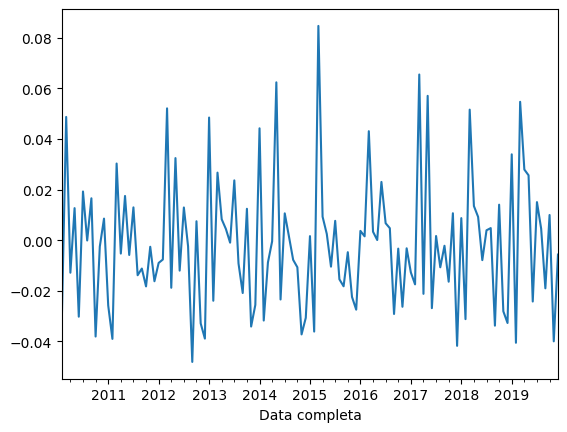

In [19]:
xdiff = X.diff()
xdiff = xdiff.dropna()
xlabel='Data'
xdiff.plot()

In [20]:
result = adfuller(xdiff)
print('ADF Estatíticas: %f' % result[0])
print('Valor de P: %f' % result[1])
print('Valores Críticos:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Estatíticas: -3.865386
Valor de P: 0.002305
Valores Críticos:
	1%: -3.493
	5%: -2.889
	10%: -2.581


#Suavização Exponencial Simples

In [21]:
X_base = X[:'2018-12-31']

In [22]:
X_base

,taxa_internacao
Data completa,
2010-01-31,0.848591
2010-02-28,0.819916
2010-03-31,0.868586
2010-04-30,0.855718
2010-05-31,0.868364
...,...
2018-08-31,0.708054
2018-09-30,0.674270
2018-10-31,0.688278


In [23]:
suavizacao_exponencial_fit = SimpleExpSmoothing(X_base).fit(smoothing_level=0.2,optimized=False) #alpha = 0.2: 20% de peso para as observações mais recentes, optimazed: acha um valor otimizado para o smoothing_level
suavizacao_exponencial_future_forecast = suavizacao_exponencial_fit.forecast(12)

In [24]:
suavizacao_exponencial_future_forecast

,0
2019-01-31,0.672944
2019-02-28,0.672944
2019-03-31,0.672944
2019-04-30,0.672944
2019-05-31,0.672944
2019-06-30,0.672944
2019-07-31,0.672944
2019-08-31,0.672944
2019-09-30,0.672944
2019-10-31,0.672944


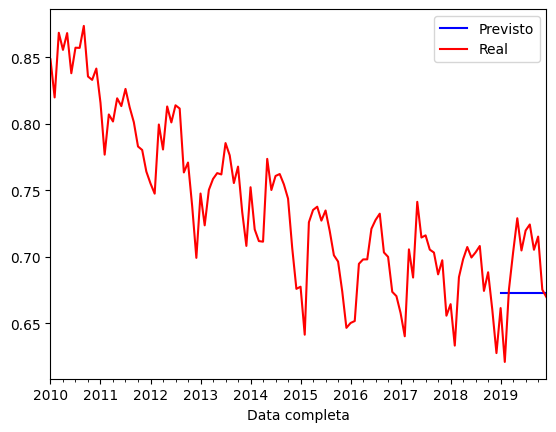

In [25]:
suavizacao_exponencial_future_forecast.plot(marker='', color='blue', legend=True, label = 'Previsto')
X.plot(marker='',  color='red', label = 'Real', legend = True)
plt.show()

In [26]:

# Parâmetros para calcular os intervalos de confiança
alpha_95 = 0.05  # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)  # Valor crítico para distribuição normal padrão
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = suavizacao_exponencial_future_forecast  # Supondo que as previsões já foram calculadas
forecast_std = np.std(X_base)  # Desvio padrão dos dados históricos

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

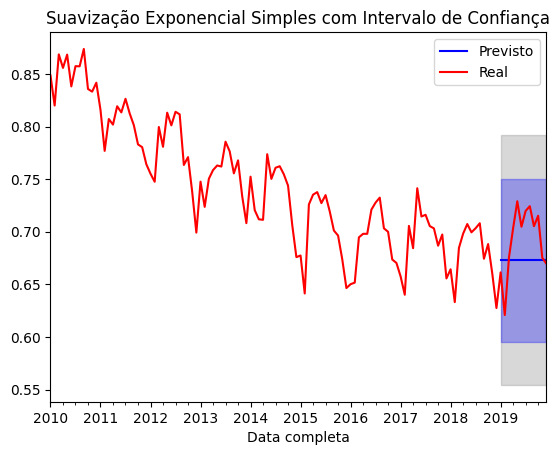

In [27]:
suavizacao_exponencial_future_forecast.plot(marker='', color='blue', legend=True, label = 'Previsto')
X.plot(marker='',  color='red', label = 'Real', legend = True)

# Plotar intervalo de confiança
plt.fill_between(suavizacao_exponencial_future_forecast.index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(suavizacao_exponencial_future_forecast.index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

plt.title('Suavização Exponencial Simples com Intervalo de Confiança')

plt.show()

In [28]:
real = X['2019-01-01':]

In [29]:
real

,taxa_internacao
Data completa,
2019-01-31,0.661335
2019-02-28,0.620791
2019-03-31,0.675440
2019-04-30,0.703329
2019-05-31,0.728952
2019-06-30,0.704707
2019-07-31,0.719730
2019-08-31,0.724261
2019-09-30,0.705227


In [30]:
mean_absolute_error(real, suavizacao_exponencial_future_forecast)

0.030226836216176323

In [31]:
np.sqrt(mean_squared_error(real, suavizacao_exponencial_future_forecast))

0.03604843037175904

In [32]:
mean_absolute_percentage_error(real, suavizacao_exponencial_future_forecast)

0.043294043160867095

In [33]:
real

,taxa_internacao
Data completa,
2019-01-31,0.661335
2019-02-28,0.620791
2019-03-31,0.675440
2019-04-30,0.703329
2019-05-31,0.728952
2019-06-30,0.704707
2019-07-31,0.719730
2019-08-31,0.724261
2019-09-30,0.705227


#SARIMA


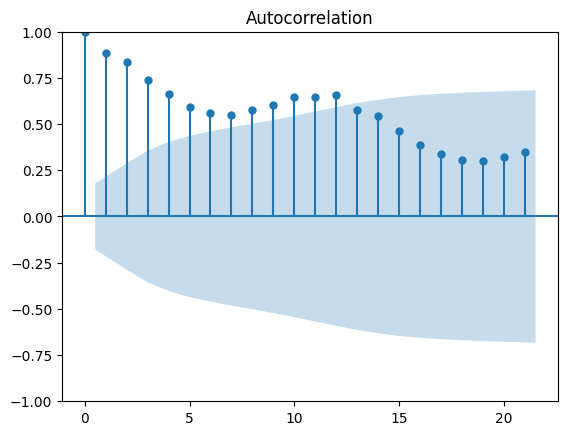

In [34]:
plot_acf(X)
plt.show()

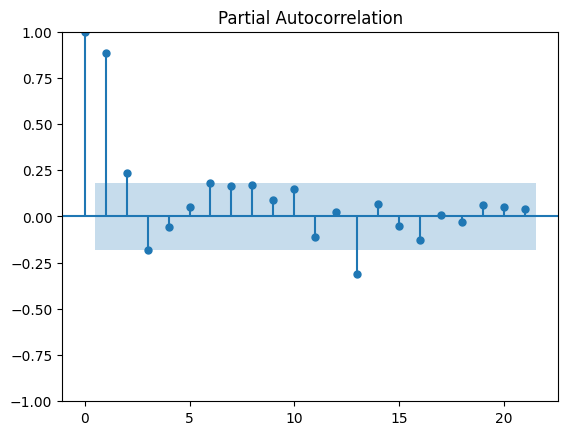

In [35]:
plot_pacf(X, method='ywm')
plt.show()

In [36]:
acorr_ljungbox(X, lags=[24])

,lb_stat,lb_pvalue
24,979.179294,2.348361e-191


In [37]:
sarima_model = auto_arima(X,start_p=1, start_q=1,max_p=6, max_q=6, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-549.558, Time=0.76 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-486.357, Time=0.17 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-514.632, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-549.121, Time=0.57 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-514.122, Time=0.48 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=-547.620, Time=1.56 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=-547.562, Time=2.09 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=-531.294, Time=0.90 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=4.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=4.80 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=-548.016, Time=7.72 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-548.636, Time=9.12 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-550.160, Time=1.39 sec
 ARIMA(0,1,2)(0,1,0)[12]          

In [38]:
print(sarima_model.aic())

-550.1599474154398


In [39]:
train = X.loc[:'2018-12-31']
test = X.loc['2019-01-01':]

In [40]:
sarima_model.fit(train)

ARIMA(order=(0, 1, 2), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [41]:
sarima_future_forecast = sarima_model.predict(n_periods=12)

In [42]:
sarima_future_forecast.index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

In [43]:
sarima_future_forecast

,0
2019-01-31,0.640705
2019-02-28,0.619249
2019-03-31,0.664929
2019-04-30,0.663125
2019-05-31,0.685298
2019-06-30,0.675329
2019-07-31,0.685046
2019-08-31,0.681009
2019-09-30,0.662782
2019-10-31,0.657800


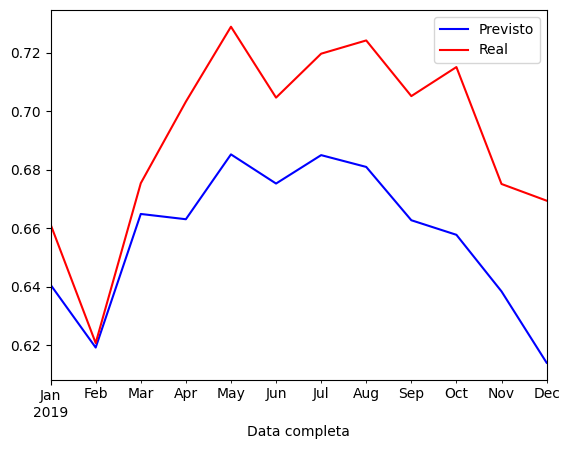

In [44]:
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
test.plot(marker='', color='red', label='Real', legend=True)

plt.show()

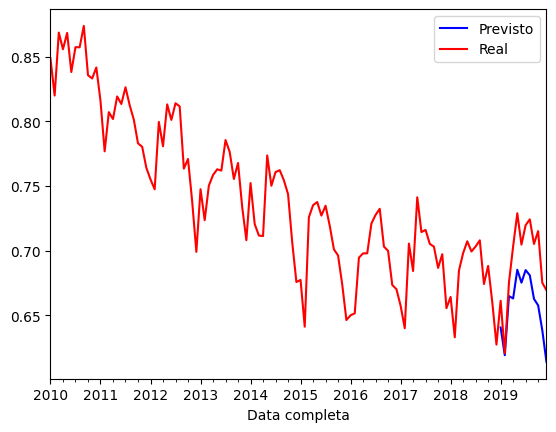

In [45]:
sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.show()

In [46]:

# Parâmetros para calcular os intervalos de confiança
alpha_95 = 0.05  # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)  # Valor crítico para distribuição normal padrão
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = sarima_future_forecast  # Supondo que as previsões já foram calculadas
forecast_std = np.std(X_base)  # Desvio padrão dos dados históricos

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

In [47]:
sarima_future_forecast.index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

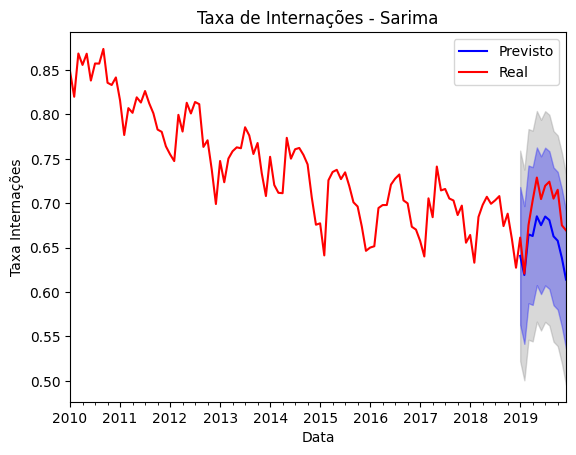

In [48]:

sarima_future_forecast.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.title('Taxa de Internações - Sarima')
plt.ylabel('Taxa Internações')
plt.xlabel('Data')

plt.fill_between(sarima_future_forecast.index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(sarima_future_forecast.index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

In [49]:
# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test,sarima_future_forecast)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(test,sarima_future_forecast)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

mape = mean_absolute_percentage_error(test,sarima_future_forecast)
print(f'MAPE: {mape}')

TU = theil_u2(test, sarima_future_forecast)
print(f'TU: {TU}')

MAE: 0.03465012157761261
MSE: 0.0014590535314109806
RMSE: 0.038197559233686396
MAPE: 0.0494538761884426
TU: 1.3111217302872487


In [50]:
model_fit = sarima_model.fit(train)

In [51]:
durbin_watson(model_fit.resid())

1.306616740969371

#ARIMA

In [52]:
arima_model = auto_arima(X,
                         start_p=1, start_q=1,
                         max_p=6, max_q=6,
                         seasonal=False,  # Definindo como False para um modelo ARIMA
                         d=1, D=1,
                         trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-535.238, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-526.474, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-535.313, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-532.637, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-528.077, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-535.863, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-533.865, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-533.858, Time=0.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-531.882, Time=1.42 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-537.352, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-536.645, Time=0.09 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-535.359, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-535.355, Time=1.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-536.646, Time=0.39 sec
 ARIMA(3,1,1)(0,0,0)[0]          

In [53]:
arima_model.fit(train)

ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [54]:
future_forecast_arima = arima_model.predict(n_periods=12)

In [55]:
future_forecast_arima.index

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='M')

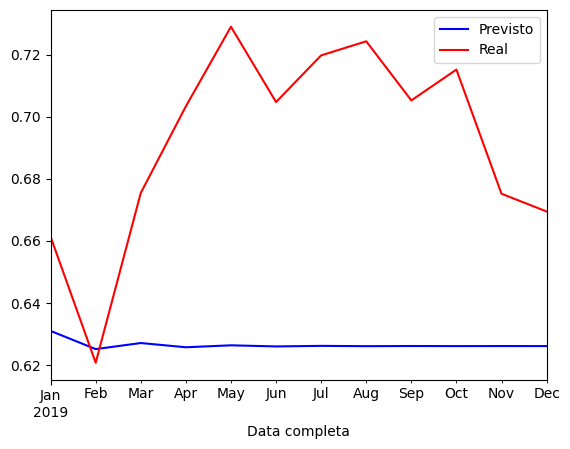

In [56]:
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
test.plot(marker='', color='red', label='Real', legend=True)

plt.show()

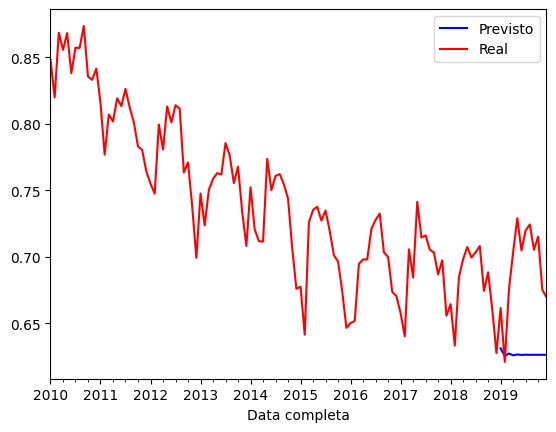

In [57]:
future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.show()

In [58]:
# Parâmetros para calcular os intervalos de confiança
alpha_95 = 0.05  # Nível de significância para intervalo de confiança de 95%
alpha_80 = 0.2
z_critical_95 = stats.norm.ppf(1 - alpha_95 / 2)  # Valor crítico para distribuição normal padrão
z_critical_80 = stats.norm.ppf(1 - alpha_80 / 2)

# Calcular intervalo de confiança
forecast_mean = future_forecast_arima  # Supondo que as previsões já foram calculadas
forecast_std = np.std(X_base)  # Desvio padrão dos dados históricos

lower_bound_95 = forecast_mean - z_critical_95 * forecast_std
upper_bound_95 = forecast_mean + z_critical_95 * forecast_std

lower_bound_80 = forecast_mean - z_critical_80 * forecast_std
upper_bound_80 = forecast_mean + z_critical_80 * forecast_std

In [59]:
future_forecast_arima

,0
2019-01-31,0.631029
2019-02-28,0.625173
2019-03-31,0.627130
2019-04-30,0.625766
2019-05-31,0.626393
2019-06-30,0.626034
2019-07-31,0.626216
2019-08-31,0.626118
2019-09-30,0.626169
2019-10-31,0.626142


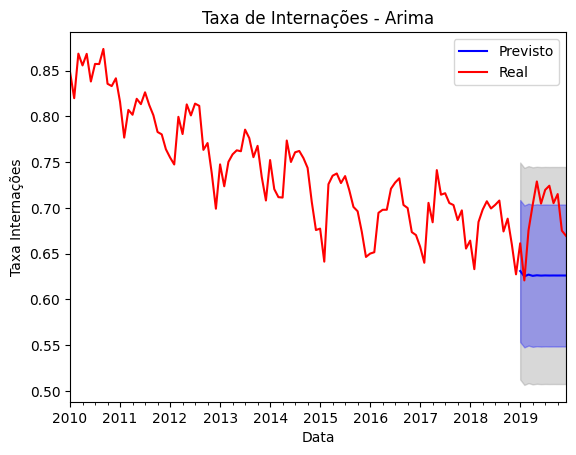

In [60]:

future_forecast_arima.plot(marker='', color='blue', legend=True, label='Previsto')
X.plot(marker='', color='red', label='Real', legend=True)

plt.title('Taxa de Internações - Arima')
plt.ylabel('Taxa Internações')
plt.xlabel('Data')

plt.fill_between(future_forecast_arima.index, lower_bound_95, upper_bound_95, color='gray', alpha=0.3, label='Intervalo de Confiança (95%)')
plt.fill_between(future_forecast_arima.index, lower_bound_80, upper_bound_80, color='blue', alpha=0.3, label='Intervalo de Confiança (80%)')

In [61]:
# Calcular o Erro Absoluto Médio (MAE)
mae = mean_absolute_error(test,future_forecast_arima)
print(f'MAE: {mae}')

# Calcular o Erro Quadrático Médio (MSE)
mse = mean_squared_error(test,future_forecast_arima)
print(f'MSE: {mse}')

# Calcular a Raiz do Erro Quadrático Médio (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

mape = mean_absolute_percentage_error(test,future_forecast_arima)
print(f'MAPE: {mape}')

TU = theil_u2(test, future_forecast_arima)
print(f'TU: {TU}')

MAE: 0.06615660659570753
MSE: 0.005235609969641213
RMSE: 0.07235751494932101
MAPE: 0.09386361915900966
TU: 2.4866748467154216


In [62]:
model_fit = arima_model.fit(train)

In [63]:
durbin_watson(model_fit.resid())

1.1412116104128491

In [64]:
!pip freeze > requirements.txt